In [46]:
devtools::install("../../elasticproc2d", quiet=TRUE, quick=TRUE)

In [47]:
library(elasticproc2d)
library(ggplot2)
library(dplyr)

In [48]:
curve <- function(t){
  rbind(t*cos(13*t), t*sin(13*t))
}
set.seed(18)
data_curves <- lapply(1:4, function(i){
  m <- sample(10:15, 1)
  delta <- abs(rnorm(m, mean = 1, sd = 0.05))
  t <- cumsum(delta)/sum(delta)
  data.frame(t(curve(t)) + 0.07*t*matrix(cumsum(rnorm(2*length(delta))),
             ncol = 2))
})

#randomly rotate and scale curves
rand_scale <- function(curve){ ( 0.5 + runif(1) ) * curve }
rand_rotate <- function(curve){
  names <- colnames(curve)
  theta <- 2*pi*runif(1)
  mat <- matrix(c(cos(theta), sin(theta), -sin(theta), cos(theta)), nrow = 2, ncol = 2)
  curve.rot <- as.matrix(curve) %*% t(mat)
  curve.rot <- as.data.frame(curve.rot)
  colnames(curve.rot) <- names
  return(curve.rot)
}
data_curves <- lapply(data_curves, rand_scale)
data_curves <- lapply(data_curves, rand_rotate)

In [49]:
source("../scripts/load_datasets.R")
set.seed(18)
#data_curves <- curves.digit3(rotate=TRUE, scale=TRUE, center=FALSE)
data_curves <- curves.spiral(n_curves = 10, rotate=TRUE, scale=TRUE, center=FALSE)

In [50]:
knots <- seq(0, 1, length = 19)
elastic_proc2d_mean <- compute_elastic_proc2d_mean(data_curves, knots = knots, type = "smooth", penalty = 2, pfit_method = "smooth")

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

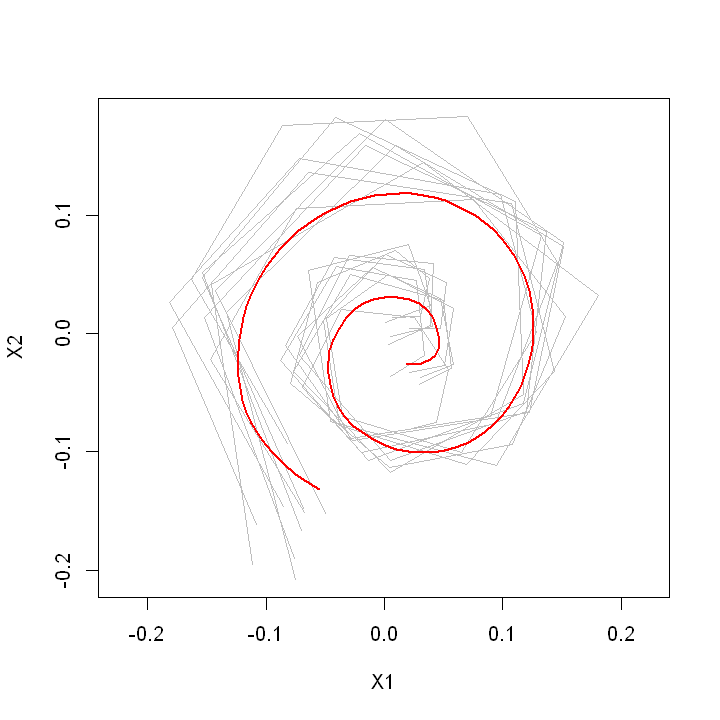

In [51]:
options(repr.plot.width=6, repr.plot.height=6)
plot(elastic_proc2d_mean)

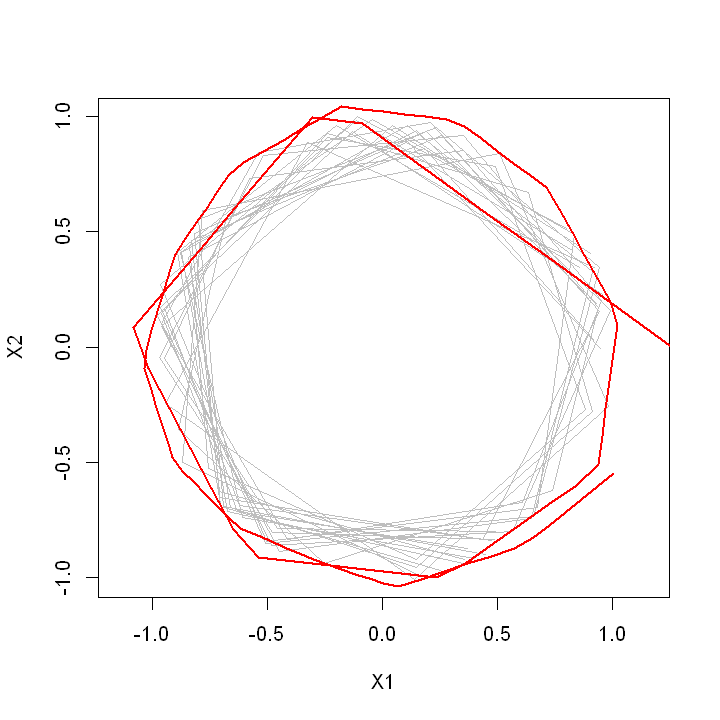

In [52]:
options(repr.plot.width=6, repr.plot.height=6)
plot(elastic_proc2d_mean, srv = TRUE)

#### Check normalization and lengths.

In [53]:
lens <- sapply(elastic_proc2d_mean$data_curves, function(curve){
    test <- get_procrustes_fit(curve)
    dx <- diff(test$X1)
    dy <- diff(test$X2)
    sum(sqrt(dx^2 + dy^2))
})
print(lens)

 [1] 1.232233 1.206130 1.248453 1.161858 1.168333 1.257422 1.235021 1.183553
 [9] 1.200114 1.239317


In [54]:
srv_norms <- sapply(elastic_proc2d_mean$data_curves, function(curve){
    test <- get_procrustes_fit(curve)
    test$t <- test$t_optim
    test$t_optim <- NULL
    test_srv <- elasdics::get_srv_from_points(test)
    compl <- complex(real = test_srv$X1, imaginary = test_srv$X2)
    sqrt(sum(diff(c(test_srv$t, 1)) * Conj(compl) * compl))
})
print(srv_norms)

 [1] 1.110060-0i 1.098239-0i 1.117342+0i 1.077895-0i 1.080895-0i 1.121348-0i
 [7] 1.111315-0i 1.087912-0i 1.095497-0i 1.113246+0i


In [55]:
test_mean <- get_evals(elastic_proc2d_mean)
dx_mean <- diff(test_mean$X1)
dy_mean <- diff(test_mean$X2)
sum(sqrt(dx_mean^2 + dy_mean^2))

[1] 0.9992834

In [56]:
test_mean_srv <- get_evals(elastic_proc2d_mean, srv=TRUE)
compl <- complex(real = test_mean_srv$X1, imaginary = test_mean_srv$X2)
sqrt(sum(0.01 * Conj(compl) * compl))

[1] 1.007425+0i

In [57]:
pfits.smooth <- lapply(seq_along(elastic_proc2d_mean$data_curves), function(j){
  knots <- elastic_proc2d_mean$knots
  type <- elastic_proc2d_mean$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% elastic_proc2d_mean$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})

pfits <- lapply(seq_along(elastic_proc2d_mean$data_curves), function(j){
    center_curve(elastic_proc2d_mean$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves[[j]])
})

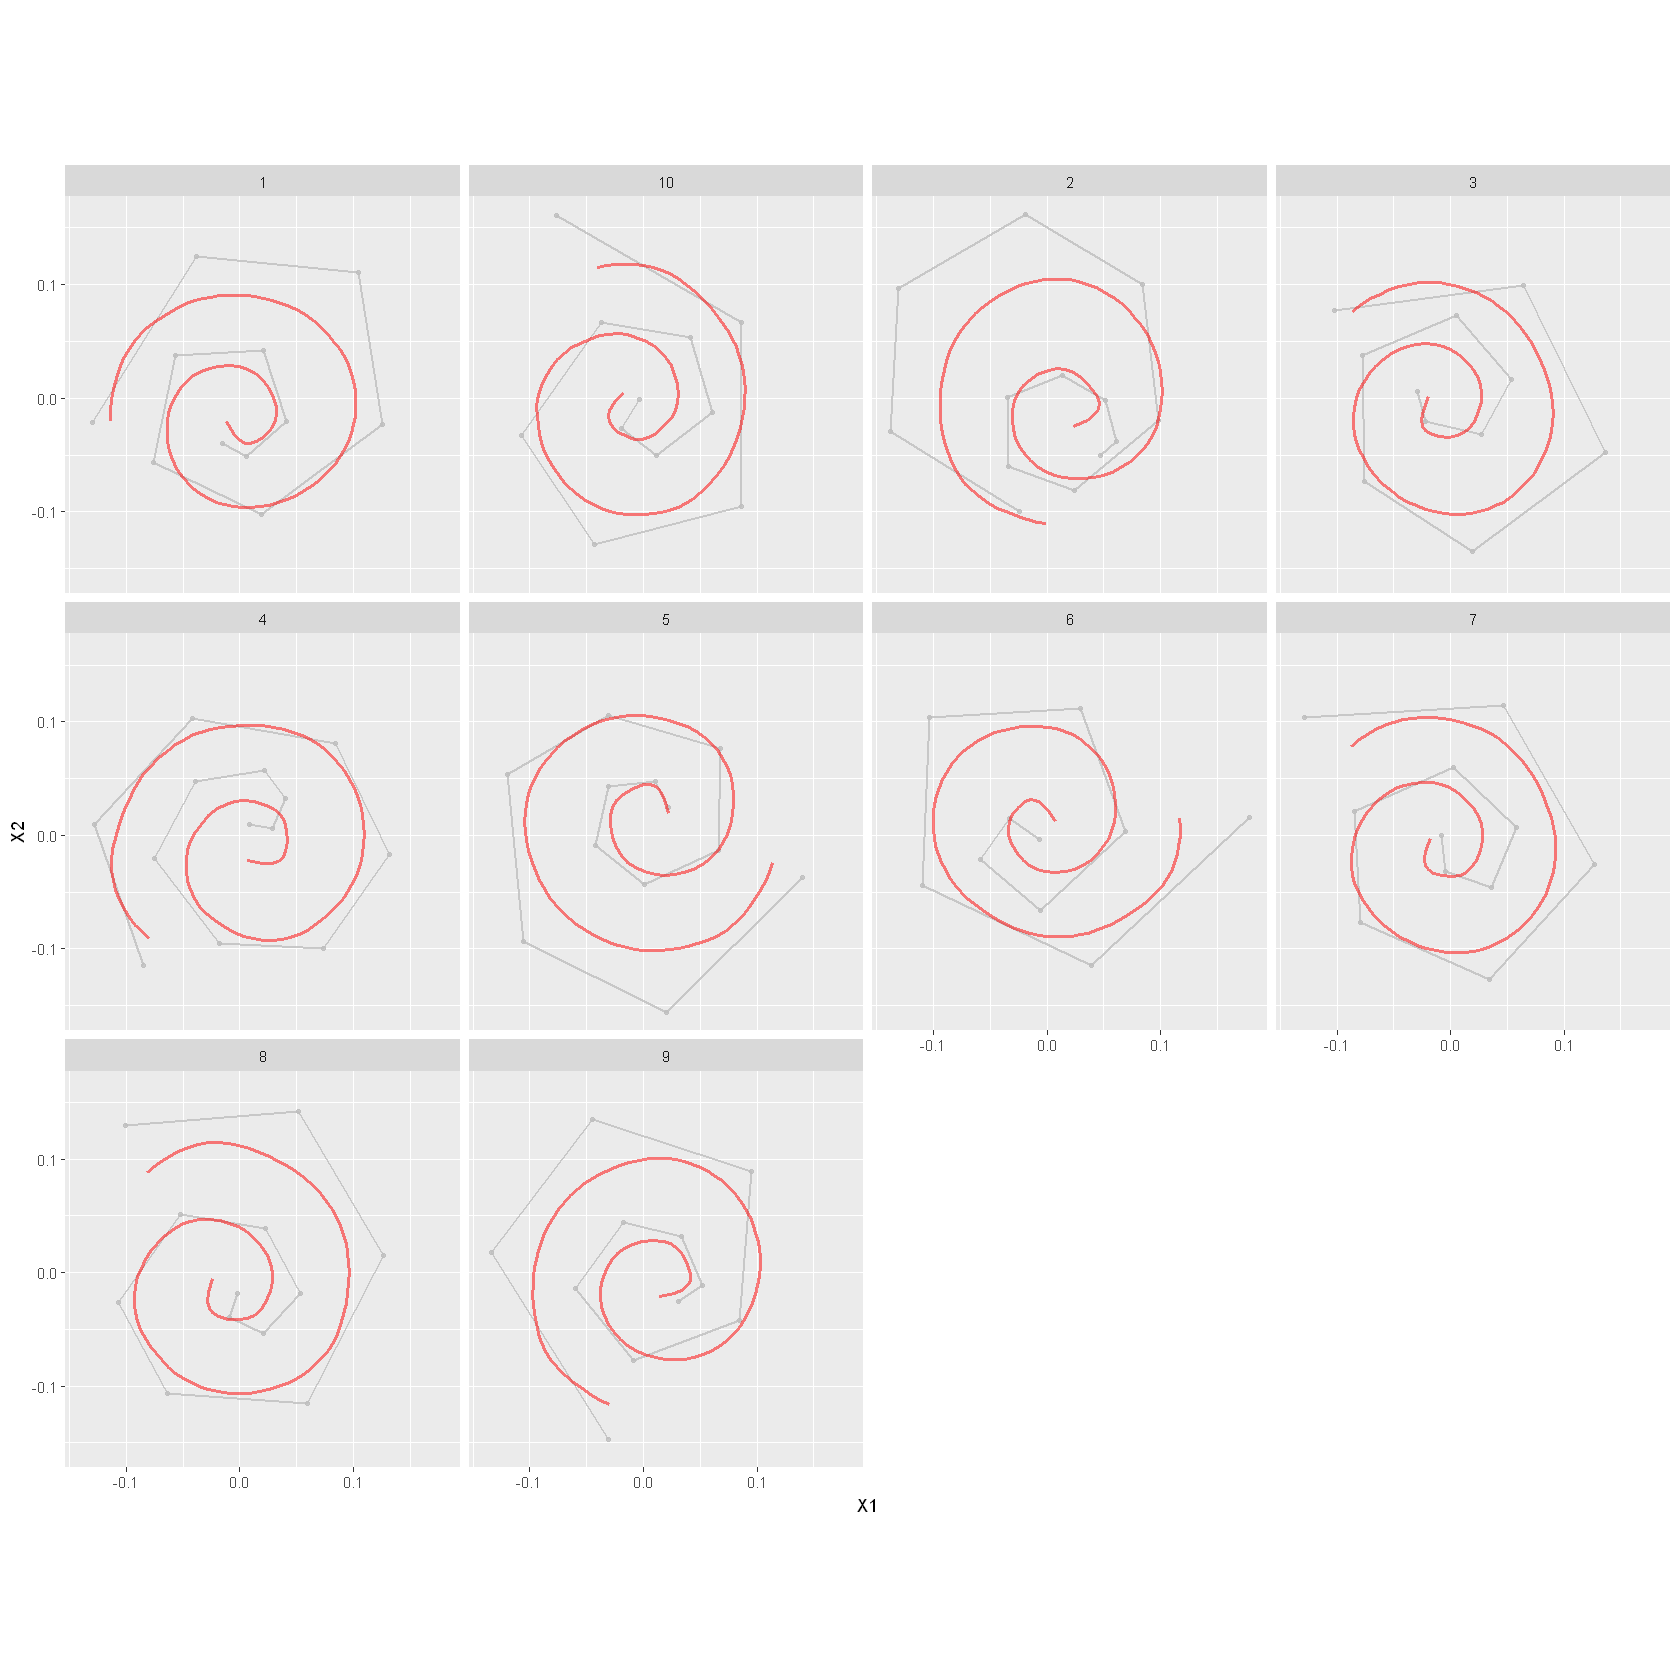

In [58]:
options(repr.plot.width=14, repr.plot.height=14)
ggplot(bind_rows(pfits.smooth, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id)